# Final Project: Model Code
### Nasiba Adilova, Heather Leighton-Dick, Madison Massie

In [1]:
#libraries/modules
import psycopg2
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
from collections import Counter
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from ann_visualizer.visualize import ann_viz

## Importing the Dataset, Cleaning, Renaming Columns
### Preprocessing

In [2]:
df_glass = pd.read_csv('glass.csv')
df_glass

RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]

In [3]:
# checking for nulls
df_glass.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [4]:
# checking for na
df_glass.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [5]:
# checking for duplicates
df_glass[df_glass.duplicated()]

RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
39  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1

In [6]:
# one duplicate found and drop it.
df_glass.drop_duplicates(keep='last',inplace=True)

In [7]:
# checking one more time to make sure there is no duplicates.
df_glass.duplicated().sum()

0

In [8]:
# data is clean now
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


In [9]:
# renaming columns for better understanding.
df_glass.rename(columns = {'RI':'RI/Refractive index', 'Na':'Na/Sodium', 'Mg': 'MG/Magnesium', 
                           'Al': 'Al/Aluminum', 'Si': 'Si/Silicon', 'K':'K/Potassium', 'Ca':'Ca/Calcium',
                           'Ba': 'Ba/Barium', 'Fe': 'Fe/Iron' }, inplace = True)
df_glass

RI/Refractive index  Na/Sodium  MG/Magnesium  Al/Aluminum  Si/Silicon  \
0                1.52101      13.64          4.49         1.10       71.78   
1                1.51761      13.89          3.60         1.36       72.73   
2                1.51618      13.53          3.55         1.54       72.99   
3                1.51766      13.21          3.69         1.29       72.61   
4                1.51742      13.27          3.62         1.24       73.08   
..                   ...        ...           ...          ...         ...   
209              1.51623      14.14          0.00         2.88       72.61   
210              1.51685      14.92          0.00         1.99       73.06   
211              1.52065      14.36          0.00         2.02       73.42   
212              1.51651      14.38          0.00         1.94       73.61   
213              1.51711      14.23          0.00         2.08       73.36   

     K/Potassium  Ca/Calcium  Ba/Barium  Fe/Iron  Type  
0           0.06        8.75       0.00      0.0     1  
1           0.48        7.83       0.00      0.0     1  
2           0.39        7.78       0.00      0.0     1  
3           0.57        8.22       0.00      0.0     1  
4           0.55        8.07       0.00      0.0     1  
..           ...         ...        ...      ...   ...  
209         0.08        9.18       1.06      0.0     7  
210         0.00        8.40       1.59      0.0     7  
211         0.00        8.44       1.64      0.0     7  
212         0.00        8.48       1.57      0.0     7  
213         0.00        8.62       1.67      0.0     7  

[213 rows x 10 columns]

#### Objective: determine which class the glass sample belongs to

There are seven types of glass listed, they are:
- Class 1: building windows(float processed)
- Class 2: biulding windows(non-float processed)
- Class 3: vehicle windows(float processed)
- Class 4: vehicle windows(non-flaot processed)
- Class 5: containers
- Class 6: tableware
- Class 7: headlamps

Pie plot to visually demonstrate break down by glass types

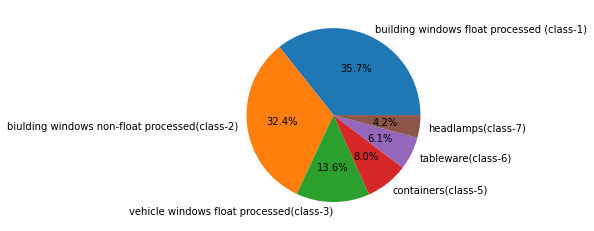

In [10]:
# pie plot: 
value_type = np.array(df_glass["Type"].value_counts())
name_type = ["building windows float processed (class-1)","biulding windows non-float processed(class-2)","vehicle windows float processed(class-3)","containers(class-5)","tableware(class-6)","headlamps(class-7)"]
plt.pie(value_type,labels = name_type, autopct='%1.1f%%')
#plt.legend(title = "Target Variable Distribution")
plt.show()

In [11]:
#using describe to understand data better.
df_glass.describe()

RI/Refractive index   Na/Sodium  MG/Magnesium  Al/Aluminum  Si/Silicon  \
count           213.000000  213.000000    213.000000   213.000000  213.000000   
mean              1.518348   13.404085      2.679202     1.449484   72.655070   
std               0.003033    0.816662      1.443691     0.495925    0.773998   
min               1.511150   10.730000      0.000000     0.290000   69.810000   
25%               1.516520   12.900000      2.090000     1.190000   72.280000   
50%               1.517680   13.300000      3.480000     1.360000   72.790000   
75%               1.519150   13.810000      3.600000     1.630000   73.090000   
max               1.533930   17.380000      4.490000     3.500000   75.410000   

       K/Potassium  Ca/Calcium   Ba/Barium     Fe/Iron        Type  
count   213.000000  213.000000  213.000000  213.000000  213.000000  
mean      0.498873    8.954085    0.175869    0.057277    2.788732  
std       0.653185    1.425882    0.498245    0.097589    2.105130  
min       0.000000    5.430000    0.000000    0.000000    1.000000  
25%       0.130000    8.240000    0.000000    0.000000    1.000000  
50%       0.560000    8.600000    0.000000    0.000000    2.000000  
75%       0.610000    9.150000    0.000000    0.100000    3.000000  
max       6.210000   16.190000    3.150000    0.510000    7.000000

#### We can see from these plots that some features are skewed. That is why we will standardize.

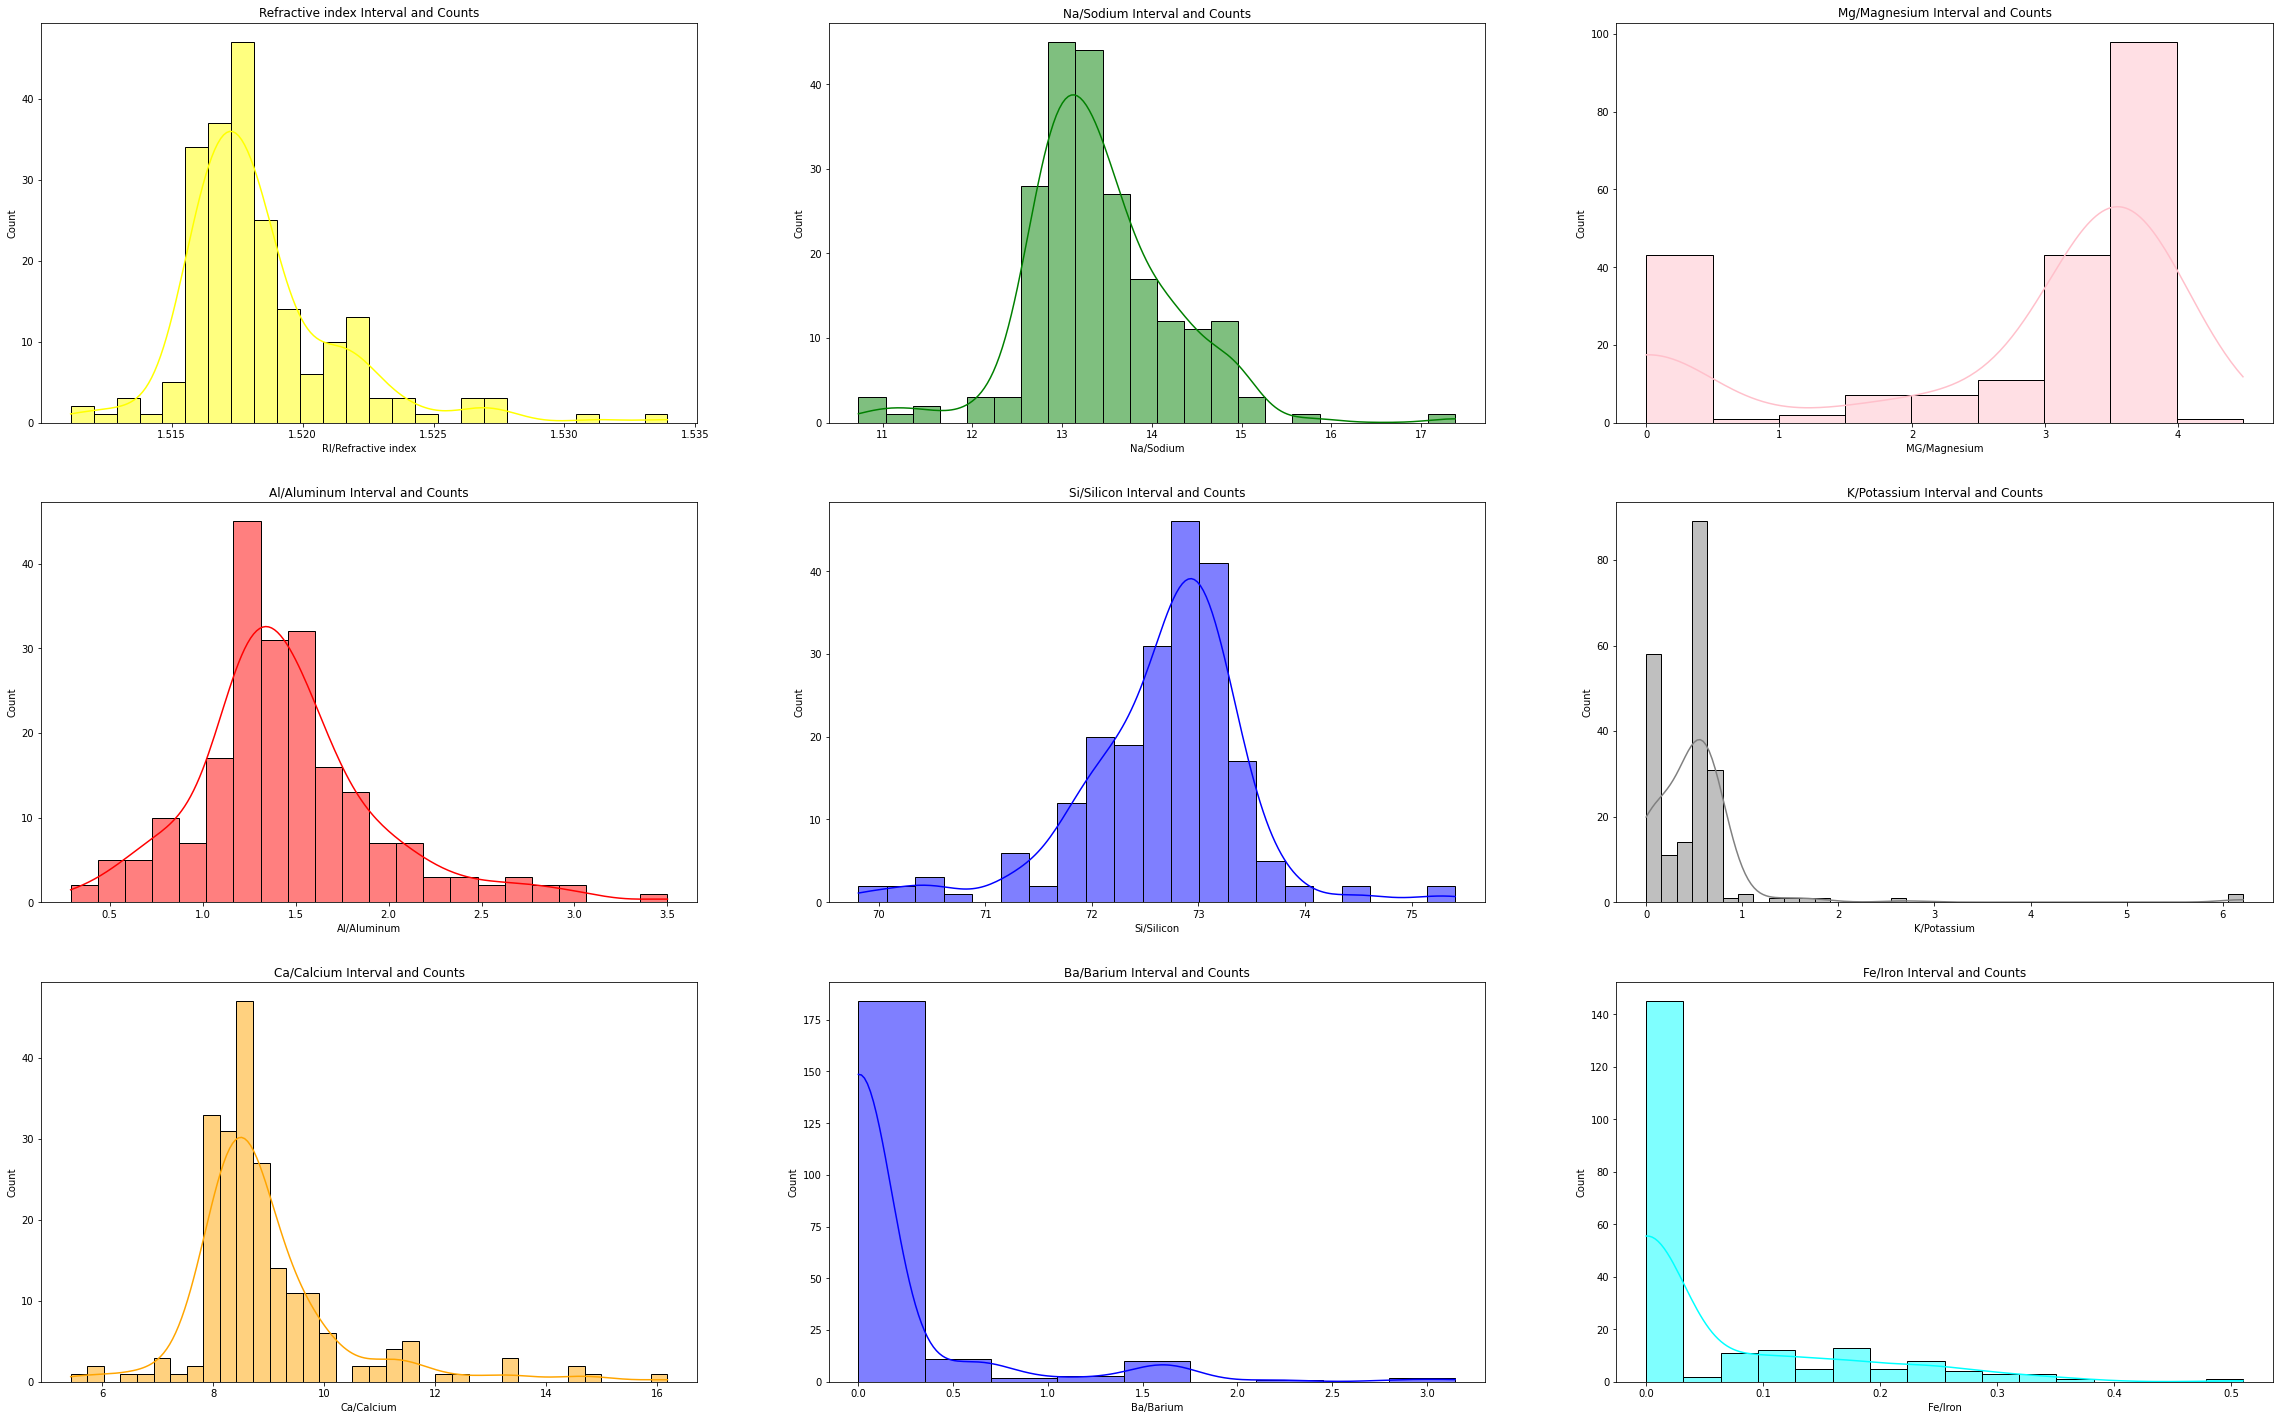

In [12]:
plt.figure(figsize=(40,25))

plt.subplot(3,3,1)
sns.histplot(df_glass['RI/Refractive index'],color = 'yellow',kde = True).set_title('Refractive index Interval and Counts')

plt.subplot(3,3,2)
sns.histplot(df_glass['Na/Sodium'],color = 'green',kde = True).set_title('Na/Sodium Interval and Counts')

plt.subplot(3,3,3)
sns.histplot(df_glass['MG/Magnesium'],kde = True,color = 'pink',).set_title('Mg/Magnesium Interval and Counts')

plt.subplot(3,3,4)
sns.histplot(df_glass['Al/Aluminum'],kde = True,color = 'red').set_title('Al/Aluminum Interval and Counts')

plt.subplot(3,3,5)
sns.histplot(df_glass['Si/Silicon'],color = 'blue',kde = True).set_title('Si/Silicon Interval and Counts')

plt.subplot(3,3,6)
sns.histplot(df_glass['K/Potassium'],color = 'grey',kde = True).set_title('K/Potassium Interval and Counts')

plt.subplot(3,3,7)
sns.histplot(df_glass['Ca/Calcium'],color = 'orange',kde = True).set_title('Ca/Calcium Interval and Counts')

plt.subplot(3,3,8)
sns.histplot(df_glass['Ba/Barium'],color = 'blue',kde = True).set_title('Ba/Barium Interval and Counts')

plt.subplot(3,3,9)
sns.histplot(df_glass['Fe/Iron'],color = 'cyan',kde = True).set_title('Fe/Iron Interval and Counts')
plt.show()

#### Correlation matrix shows us that RI/refractive index highly correlated with Ca/calcium, RI/refractive index negatively correlated with Si/silicon

RI/Refractive index  Na/Sodium  MG/Magnesium  \
RI/Refractive index             1.000000  -0.198802     -0.127526   
Na/Sodium                      -0.198802   1.000000     -0.278420   
MG/Magnesium                   -0.127526  -0.278420      1.000000   
Al/Aluminum                    -0.400973   0.167735     -0.479575   
Si/Silicon                     -0.539000  -0.064885     -0.162437   
K/Potassium                    -0.287645  -0.264158      0.007617   
Ca/Calcium                      0.811183  -0.278194     -0.446197   
Ba/Barium                       0.001679   0.329080     -0.491818   
Fe/Iron                         0.147083  -0.239374      0.085426   
Type                           -0.160140   0.508837     -0.744195   

                     Al/Aluminum  Si/Silicon  K/Potassium  Ca/Calcium  \
RI/Refractive index    -0.400973   -0.539000    -0.287645    0.811183   
Na/Sodium               0.167735   -0.064885    -0.264158   -0.278194   
MG/Magnesium           -0.479575   -0.162437     0.007617   -0.446197   
Al/Aluminum             1.000000   -0.016195     0.323683   -0.258068   
Si/Silicon             -0.016195    1.000000    -0.197281   -0.207145   
K/Potassium             0.323683   -0.197281     1.000000   -0.317032   
Ca/Calcium             -0.258068   -0.207145    -0.317032    1.000000   
Ba/Barium               0.480642   -0.104389    -0.043653   -0.112208   
Fe/Iron                -0.080583   -0.097717    -0.009372    0.126314   
Type                    0.597432    0.147725    -0.012455    0.002677   

                     Ba/Barium   Fe/Iron      Type  
RI/Refractive index   0.001679  0.147083 -0.160140  
Na/Sodium             0.329080 -0.239374  0.508837  
MG/Magnesium         -0.491818  0.085426 -0.744195  
Al/Aluminum           0.480642 -0.080583  0.597432  
Si/Silicon           -0.104389 -0.097717  0.147725  
K/Potassium          -0.043653 -0.009372 -0.012455  
Ca/Calcium           -0.112208  0.126314  0.002677  
Ba/Barium             1.000000 -0.059729  0.574896  
Fe/Iron              -0.059729  1.000000 -0.191090  
Type                  0.574896 -0.191090  1.000000

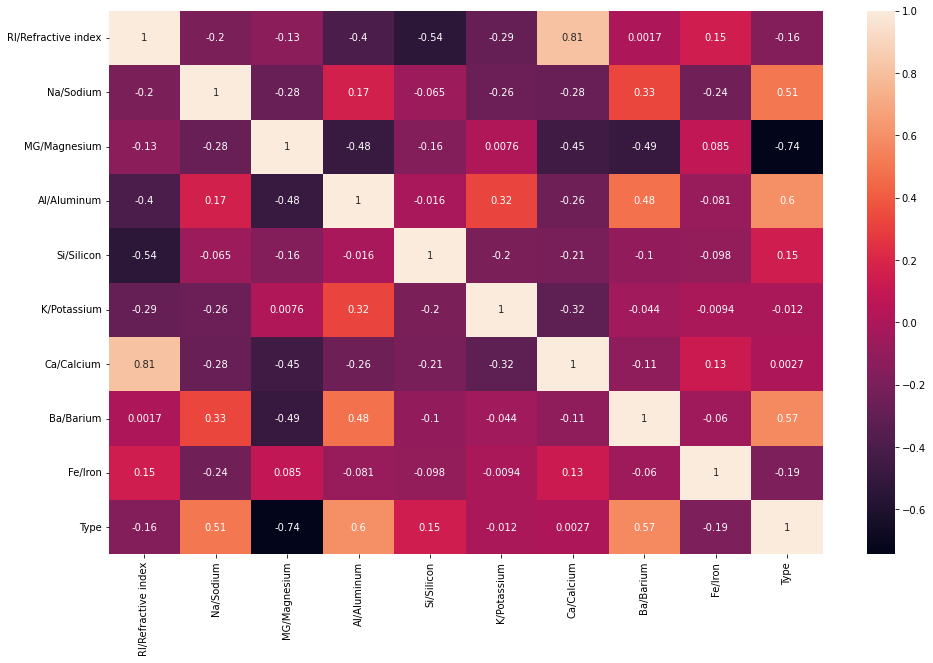

In [13]:
corr_matrix = df_glass.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix,annot=True)
corr_matrix

#### This plot is used to check wheather output are balanced or not

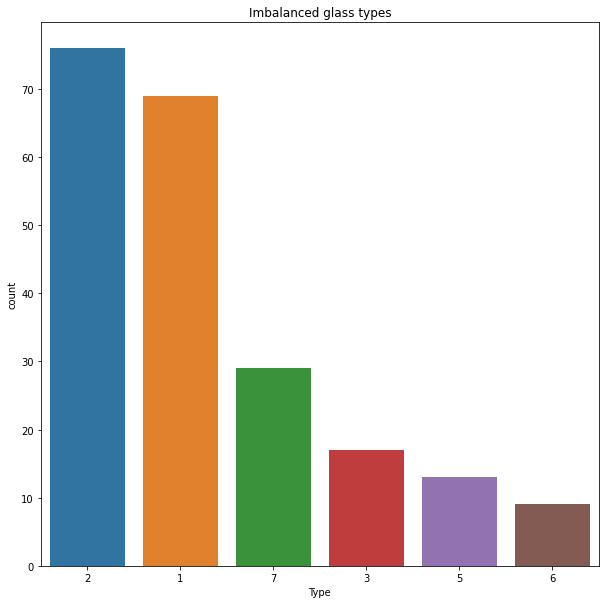

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(x='Type', data=df_glass, order=df_glass['Type'].value_counts().index).set(title='Imbalanced glass types')
#sns.set("Imbalanced glass types")
plt.show()

## Imbalanced Dataset

In [15]:
#There are no observations of Type 4 Glass in this dataset
df_glass['Type'].unique()

array([1, 2, 3, 5, 6, 7])

In [16]:
#How many observations of each Type are in the dataset?
df_glass['Type'].value_counts(sort=False)

1    69
2    76
3    17
5    13
6     9
7    29
Name: Type, dtype: int64

### Finding the Allowable Range of Chemical Amounts in Each Type of Glass ("unit measurement: weight percent in corresponding oxide", per dataset specifications)

In [17]:
#Sodium
sodiumrange_bytype = df_glass.groupby('Type').apply(lambda x: x['Na/Sodium'].max() - x['Na/Sodium'].min())
print(sodiumrange_bytype)

Type
1    2.32
2    4.13
3    2.16
5    2.98
6    3.59
7    3.84
dtype: float64


In [18]:
#Magnesium
magrange_bytype = df_glass.groupby('Type').apply(lambda x: x['MG/Magnesium'].max() - x['MG/Magnesium'].min())
print(magrange_bytype)

Type
1    1.78
2    3.98
3    0.56
5    2.68
6    2.41
7    3.34
dtype: float64


In [19]:
#Aluminum
alumrange_bytype = df_glass.groupby('Type').apply(lambda x: x['Al/Aluminum'].max() - x['Al/Aluminum'].min())
print(alumrange_bytype)

Type
1    1.40
2    1.56
3    1.18
5    2.10
6    1.75
7    1.69
dtype: float64


In [20]:
#Silicon
sirange_bytype = df_glass.groupby('Type').apply(lambda x: x['Si/Silicon'].max() - x['Si/Silicon'].min())
print(sirange_bytype)

Type
1    2.35
2    4.64
3    1.65
5    3.99
6    3.04
7    4.92
dtype: float64


In [21]:
#Potassium
Krange_by_type = df_glass.groupby('Type').apply(lambda x: x['K/Potassium'].max() - x['K/Potassium'].min())
print(Krange_by_type)

Type
1    0.69
2    1.10
3    0.61
5    6.08
6    0.00
7    2.70
dtype: float64


In [22]:
#Calcium
Carange_by_type = df_glass.groupby('Type').apply(lambda x: x['Ca/Calcium'].max() - x['Ca/Calcium'].min())
print(Carange_by_type)

Type
1    2.39
2    9.11
3    1.33
5    6.63
6    4.57
7    4.33
dtype: float64


In [23]:
#Iron
FErange_by_type = df_glass.groupby('Type').apply(lambda x: x['Fe/Iron'].max() - x['Fe/Iron'].min())
print(FErange_by_type)

Type
1    0.31
2    0.35
3    0.37
5    0.51
6    0.00
7    0.09
dtype: float64


In [24]:
#Barium
BArange_by_type = df_glass.groupby('Type').apply(lambda x: x['Ba/Barium'].max() - x['Ba/Barium'].min())
print(BArange_by_type)

Type
1    0.69
2    3.15
3    0.15
5    2.20
6    0.00
7    2.88
dtype: float64


## Applying SMOTE

In [25]:
#Function to balance outputs
def smote_balance(glass):
    data = glass.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable
    y = LabelEncoder().fit_transform(y)
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    return X, y

In [26]:
X, y = smote_balance(df_glass)

## Train Test Split and Standard Scaling

In [27]:
#Function to split and standardize data
def split_train_sc(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    #Perform Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return (X_train, X_test, y_train, y_test) 

In [28]:
#split into train test split portions
X_train, X_test, y_train, y_test = split_train_sc(X, y)

In [29]:
## Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(364, 9)
(364,)
(92, 9)
(92,)


## Support Vector Machine

### Training SVM Model Candidates (Linear, Radial Basis Function, Polynomial Kernel)
### *Linear Kernel Model*

In [30]:
# training a linear SVM classifier
svm_linmodel = SVC(kernel = 'linear', C = 1)
svm_linmodel.fit(X_train, y_train)
svm_linpredictions = svm_linmodel.predict(X_test)
 
#print accuracy and F1 score:
lin_accuracy = svm_linmodel.score(X_test, y_test)
print("Accuracy (Linear Kernel): ", "%.2f" % (lin_accuracy*100)) 
lin_f1 = f1_score(y_test, svm_linpredictions, average='weighted')
print('F1 (Linear Kernel): ', "%.2f" % (lin_f1*100))

Accuracy (Linear Kernel):  81.52
F1 (Linear Kernel):  80.04


In [31]:
print(classification_report(y_test, svm_linpredictions))

              precision    recall  f1-score   support

           0       0.64      0.82      0.72        17
           1       0.86      0.32      0.46        19
           2       0.53      0.90      0.67        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.82        92
   macro avg       0.84      0.84      0.81        92
weighted avg       0.85      0.82      0.80        92



### *Radial Basis Function Model*

In [32]:
#training an RBF classifier:
rbf = SVC(kernel='rbf', gamma=0.5, C=1).fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)

#printing accuracy and F1 scores:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  89.13
F1 (RBF Kernel):  89.13


In [33]:
print(classification_report(y_test, rbf_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.82      0.74      0.78        19
           2       0.69      0.90      0.78        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.89        92
   macro avg       0.89      0.90      0.89        92
weighted avg       0.90      0.89      0.89        92



### *Polynomial Kernel Model*

In [34]:
#training a Polynomial classifer:
poly = SVC(kernel='poly', degree=3, C=10).fit(X_train, y_train)
poly_pred = poly.predict(X_test)

#printing accuracy and F1 scores:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial kernel):  84.78
F1 (Polynomial kernel):  84.88


In [35]:
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.83      0.53      0.65        19
           2       0.50      1.00      0.67        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.85        92
   macro avg       0.87      0.87      0.85        92
weighted avg       0.88      0.85      0.85        92



#### Conclusion: The RBF Kernel method gave the best score of the three SVM models, with an accuracy of 86.96. RBF is the default SVM model, and uses C and gamma parameters

### Plotting Refractive Index v Chemical Components

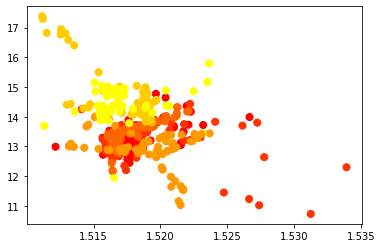

In [36]:
#refractive index v sodium
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

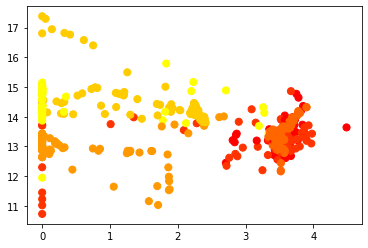

In [37]:
#refractive index v magnesium
plt.scatter(X[:, 2], X[:, 1], c=y, s=50, cmap='autumn');

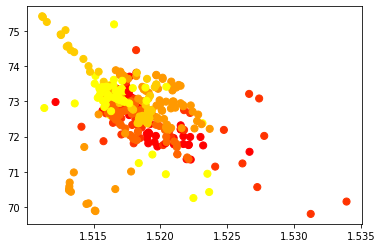

In [38]:
#refractive index v silicon
plt.scatter(X[:, 0], X[:, 4], c=y, s=50, cmap='autumn');

### Confusion Matrices for Each Model

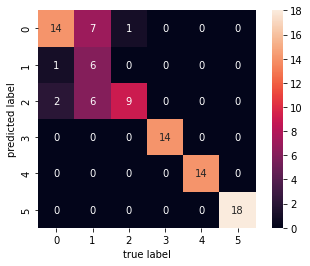

In [39]:
#Confusion matrix for Linear Kernel model
mat = confusion_matrix(y_test, svm_linpredictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

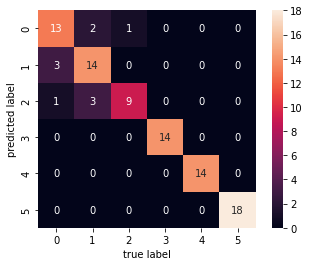

In [40]:
#Confusion Matrix for RBF model
mat = confusion_matrix(y_test, rbf_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

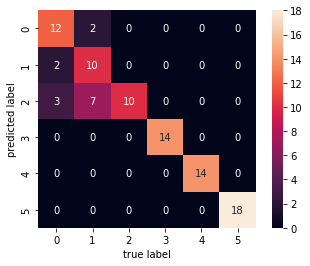

In [41]:
#Confusion Matrix for Polynomial Kernel model
mat = confusion_matrix(y_test, poly_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Plotting the SVM RBF Model

In [42]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

### ROC Curves for the RBF Model

In [43]:
#ROC function and plotting courtesy of Nasiba
def plot_roc_curve(y_test,rbf_pred):
    num_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test,classes =np.arange(num_classes))
    rbf_pred = label_binarize(rbf_pred,classes=np.arange(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_ = roc_curve(y_test[:, i],rbf_pred[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
        
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'],_ = roc_curve(y_test.ravel(),rbf_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
    
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr,fpr[i], tpr[i])
        
        
    # Finally average it and compute AUC
    mean_tpr/=num_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'],tpr['macro'])
    
    # Plot all ROC curves
    # plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr['micro'],tpr['micro'],
            label = 'Micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),
            color = 'deeppink', linestyle=':', linewidth=4,)
    
    plt.plot(fpr['macro'],tpr['macro'],
            label = 'macro-average ROC curve (area={0:0.2f})'.format(roc_auc['macro']),
            color='navy', linestyle=':',linewidth=4,)
    
    colors = ['aqua','darkorange','blue', 'yellow']
    for i, color in zip(range(num_classes),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=lw,
                label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]),)
        
        
        plt.plot([0,1],[0,1], 'k--',lw =lw)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Glass identification ROC curve')
        plt.legend()

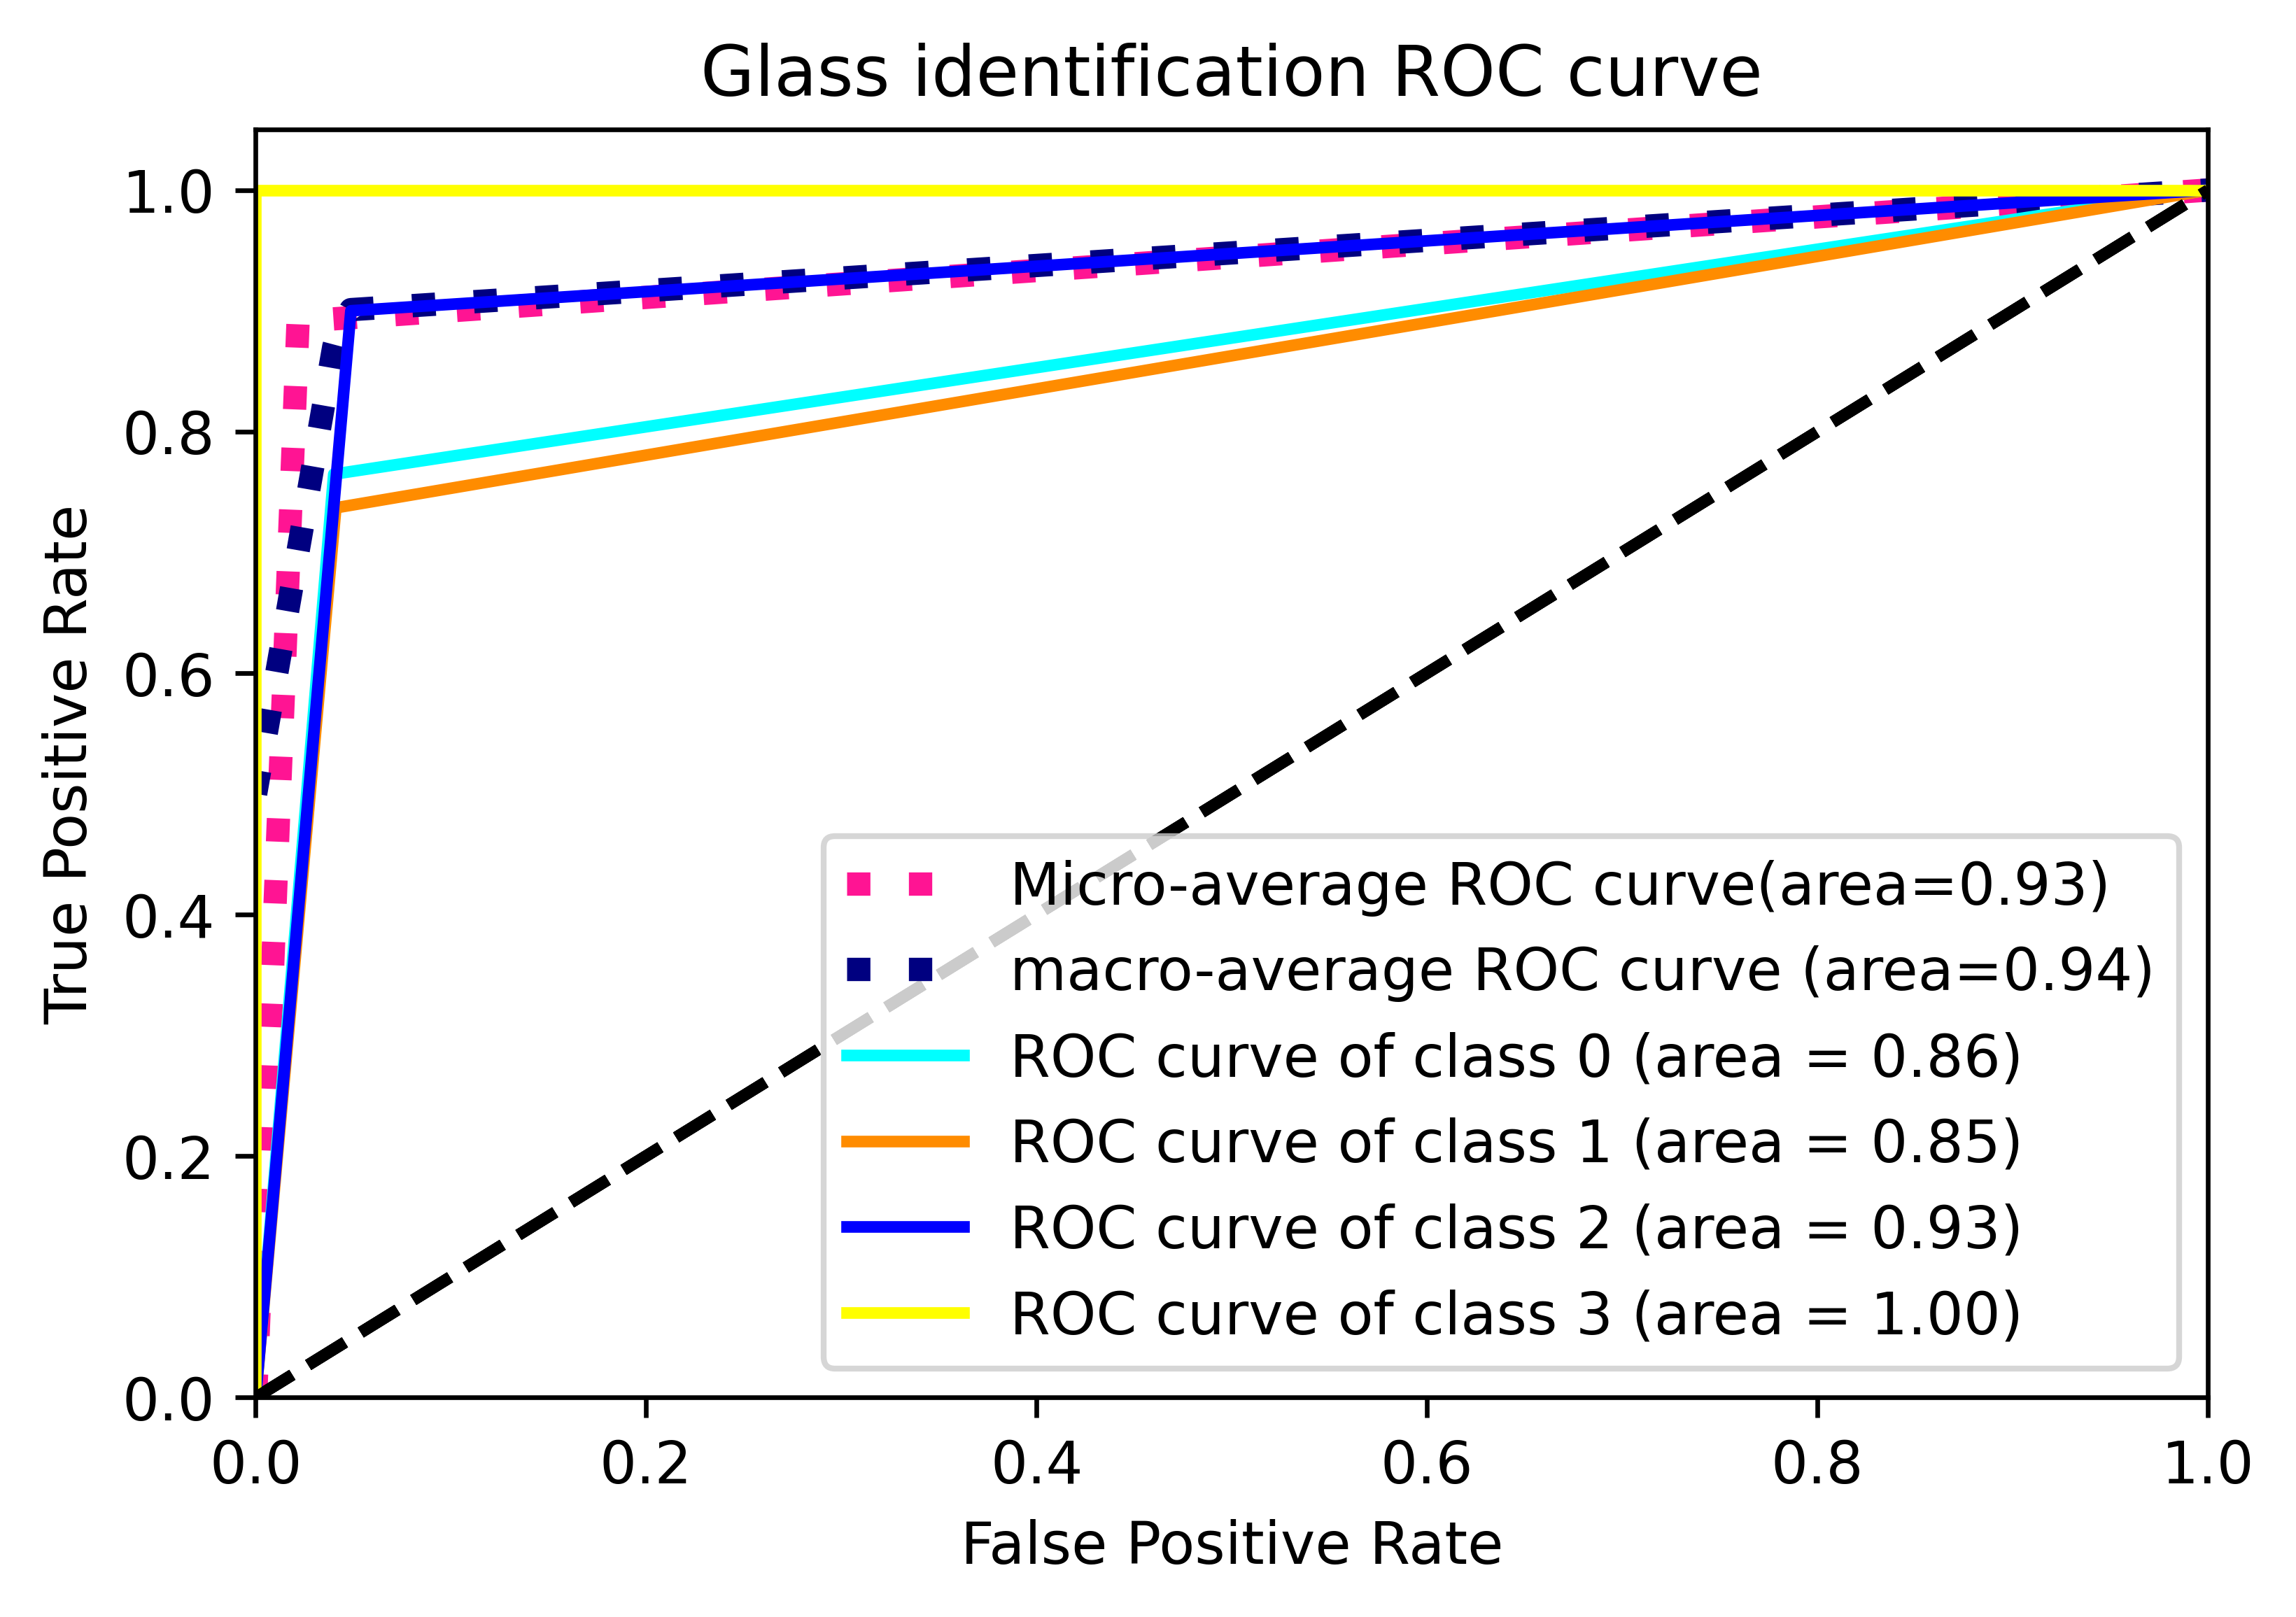

In [44]:
plot_roc_curve(y_test,rbf_pred)

## K-Nearest Neighbors
### Creating KNN Model using Functions

In [45]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size = 0.2, random_state=42)

In [46]:
def optimal_k(X_train, X_test, y_train, y_test, stop=100):
    #Initialize knn_score and k
    knn_score, k = 0, 0
    #Loop through the odd values from 3 to the stop value + 1
    for n in range(3, stop+1, 2):
        #Generate KNN object with n neighbors
        knn=KNeighborsClassifier(n_neighbors=n)
        #Fit the model using X_train and y_train
        knn.fit(X_train, y_train)
        #Check if the new score of KNN is greater than the current max KNN score
        if knn.score(X_test, y_test) > knn_score:
            #If the new score of KNN is greater, set it as the new max and save the n value
            knn_score = knn.score(X_test, y_test)
            k = n
    #Print the optimal k value and it's KNN score
    print('Optimal k:', k, 'KNN Score:',knn_score)
    return k

In [47]:
def knn_model(X_train, X_test, y_train, y_test):
    #Obtain optimal k value
    k = optimal_k(X_train, X_test, y_train, y_test)
    #Setup the parameters to test on the KNN model
    params = {'n_neighbors': [k],
              'metric': ['minkowski', 'euclidean', 'manhattan'],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(10, 100, 5),
              'p': [1, 2]}
    #Run the KNN model through the search, using the specified parameters and 5 cross-fold validation
    gs = GridSearchCV(KNeighborsClassifier(), param_grid = params, cv=5, scoring = 'accuracy')
    #Fit the search to the training data
    gs.fit(X_train, y_train)

    #Return the tuned KNN model
    return gs.best_estimator_

### Train and Test KNN Model

In [48]:
#Create a KNN object using the created function
knn = knn_model(X_train, X_test, y_train, y_test)
#Obtain the predicted y scores using X_train (to check for underfitting)
knn_train = knn.predict(X_train)
#Obtain the predicted y scores using X_test
knn_pred = knn.predict(X_test)

#Create a DataFrame of the X_test values, the features, and the true and predicted labels
knn_glass = pd.DataFrame(X_test, columns=df_glass.columns[:-1])
knn_glass['True Labels'] = y_test
knn_glass['Predicted Labels'] = knn_pred
knn_glass.head()

Optimal k: 3 KNN Score: 0.8913043478260869


RI/Refractive index  Na/Sodium  MG/Magnesium  Al/Aluminum  Si/Silicon  \
0             0.194059   0.649654      0.149044    -0.124615   -0.287774   
1            -0.081961  -0.952418      0.920687    -0.777158    0.385146   
2             1.119533  -0.783206     -1.129682    -0.042095    0.886411   
3             0.542579   0.267974      0.971990    -0.378504   -1.135195   
4            -0.610644  -0.265674      0.850144    -0.484271   -0.116492   

   K/Potassium  Ca/Calcium  Ba/Barium   Fe/Iron  True Labels  Predicted Labels  
0    -0.576910    0.204911  -0.434343 -0.516909            4                 4  
1     0.224398   -0.275287  -0.434343 -0.516909            0                 0  
2    -0.388312    1.558626  -0.434343  2.343705            3                 3  
3    -0.230777   -0.443709   0.398423 -0.516909            0                 0  
4     0.074153   -0.362566  -0.434343 -0.516909            2                 2

In [49]:
#Obtain the accuracy score of the training data (to check for underfitting)
print(accuracy_score(y_train, knn_train))

1.0


In [50]:
#Obtain the accuracy score of the test data (to check for overfitting and for the model's accuracy)
print(accuracy_score(y_test, knn_pred))

0.9021739130434783


In [51]:
#Generate the classification report for the model
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       1.00      0.74      0.85        19
           2       0.62      1.00      0.77        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.90        92
   macro avg       0.91      0.92      0.90        92
weighted avg       0.92      0.90      0.90        92



### Feature Selection

In [52]:
#Run several feature selection functions using X and y
mi = mutual_info_classif(X, y, random_state=42)
f_score, _ = f_classif(X, y)
sp = SelectPercentile(chi2, percentile=10).fit(X, y)
#Create a DataFrame of the features and their scores
feats = pd.DataFrame(zip(df_glass.columns[:-1], mi, f_score, sp.scores_),
                  columns=['Feats', 'MI', 'F_Score', 'Chi-10'])
feats

Feats        MI     F_Score      Chi-10
0  RI/Refractive index  0.544886    6.212825    0.000132
1            Na/Sodium  0.622552  114.164196   15.225813
2         MG/Magnesium  0.755062  254.115958  396.641068
3          Al/Aluminum  0.586722   79.347382   41.281500
4           Si/Silicon  0.422076    8.183890    0.315875
5          K/Potassium  0.727275   26.584525  143.954696
6           Ca/Calcium  0.616557   21.665423   18.281390
7            Ba/Barium  0.449484  135.889038  337.223922
8              Fe/Iron  0.139870   10.449308    8.241062

In [53]:
#Find the 3 features with the highest score for each function
top_3_feats = {}
for i in ['MI', 'F_Score', 'Chi-10']:
    top_3_feats[i] = feats.sort_values(by = i)['Feats'][:3].values
#Create a DataFrame of the top 3 features
top_3 = pd.DataFrame(top_3_feats)
top_3

MI              F_Score               Chi-10
0     Fe/Iron  RI/Refractive index  RI/Refractive index
1  Si/Silicon           Si/Silicon           Si/Silicon
2   Ba/Barium              Fe/Iron              Fe/Iron

### Plotting KNN

In [54]:
def convert_to_colors(y_vals):
    colors = []
    for val in y_vals:
        if val == 0:
            colors.append('seagreen')
        elif val == 1:
            colors.append('chocolate')
        elif val == 2:
            colors.append('darkslateblue')
        elif val == 3:
            colors.append('goldenrod')
        elif val == 4:
            colors.append('saddlebrown')
        else:
            colors.append('dimgrey')
    return colors

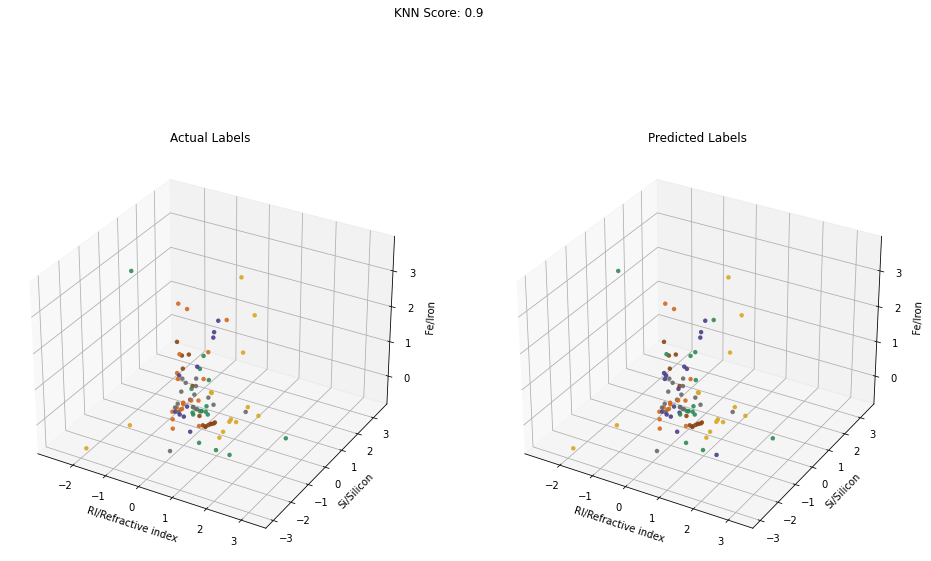

In [55]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle(f'KNN Score: {knn.score(X_test, y_test).round(2)}')
#Get the X values for the top 3 features
xs = list(X_test[:, 0])
ys = list(X_test[:, 4])
zs = list(X_test[:, 8])

#Loop through y_test and assign each class a color
true_colors = convert_to_colors(y_test)
        
#Loop through knn_pred and assign each class a color
pred_colors = convert_to_colors(knn_pred)
        
#Add a 3-D graph of X_test and color by y_test value
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(xs, ys, zs, alpha=0.9, c=true_colors, edgecolors='none')
ax1.set_xlabel(df_glass.columns[0])
ax1.set_ylabel(df_glass.columns[4])
ax1.set_zlabel(df_glass.columns[8])
ax1.set_title('Actual Labels')

#Add a 3-D graph of X_test and color by y_pred value
ax2 = fig.add_subplot(122, projection='3d')    
ax2.scatter(xs, ys, zs, alpha=0.9, c=pred_colors, edgecolors='none')
ax2.set_xlabel(df_glass.columns[0])
ax2.set_ylabel(df_glass.columns[4])
ax2.set_zlabel(df_glass.columns[8])
ax2.set_title('Predicted Labels')
plt.show()

### Plotting ROC Curve for KNN

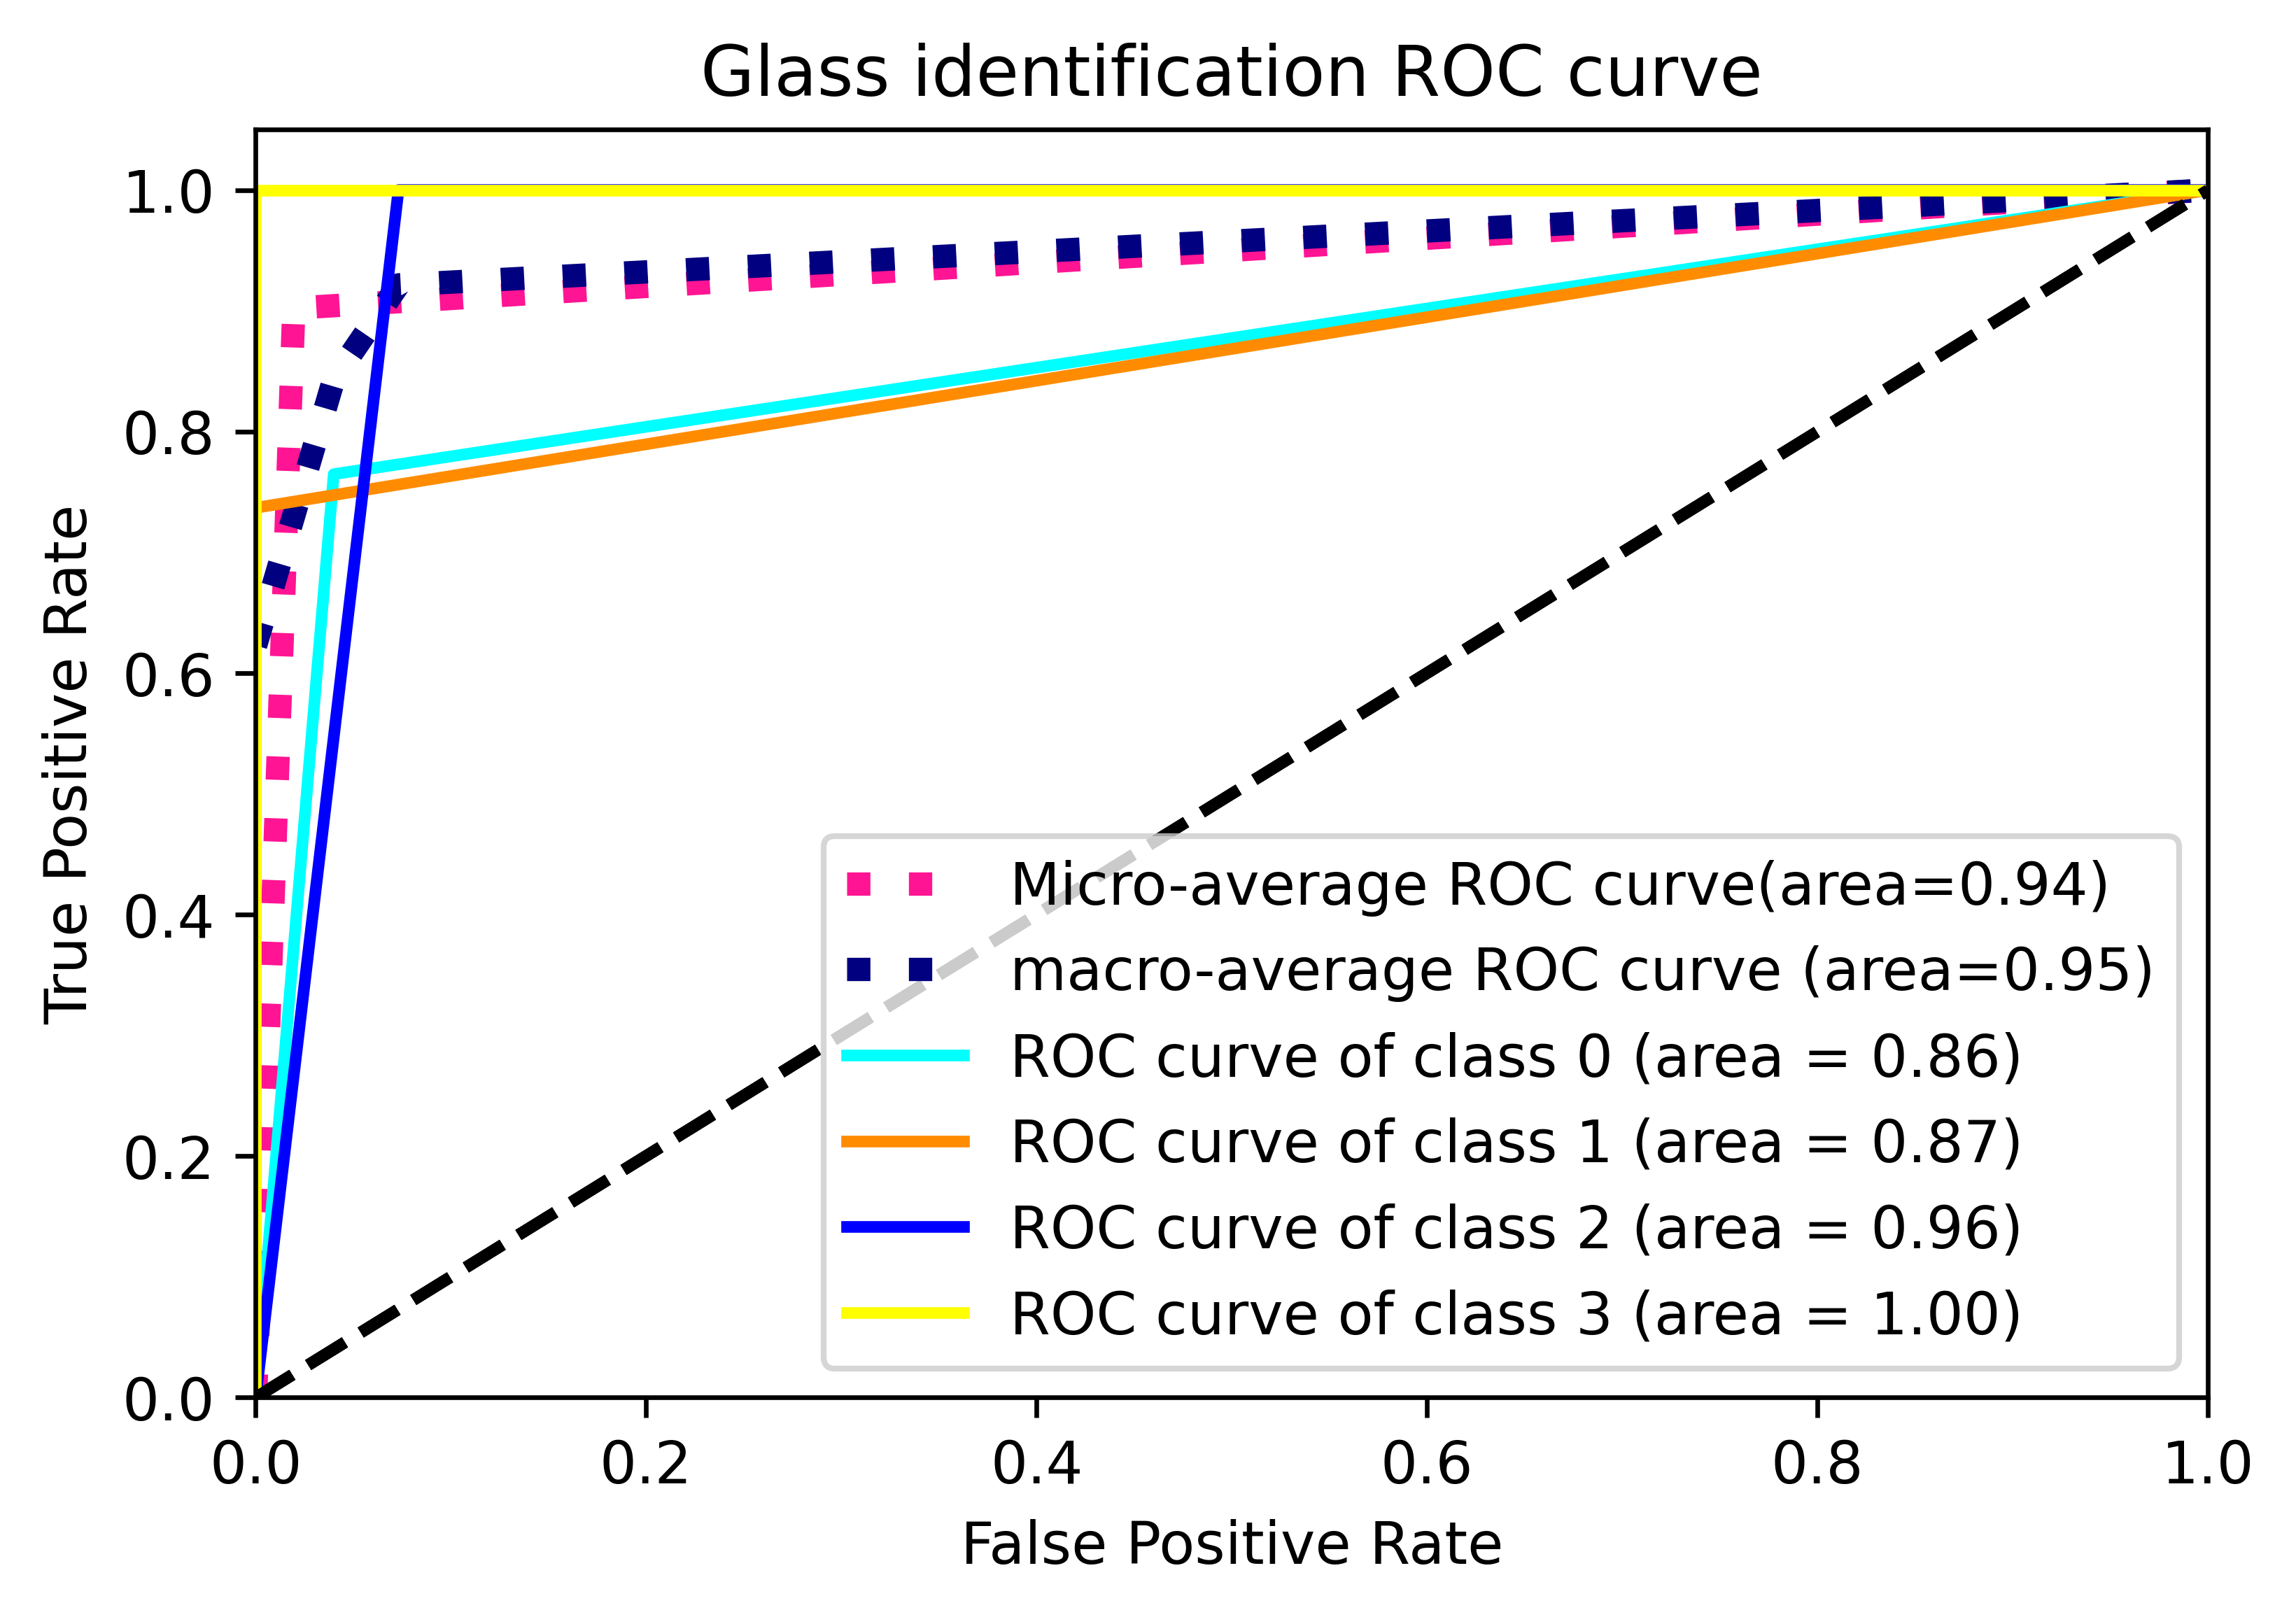

In [56]:
#Plot ROC Curve for KNN model
plot_roc_curve(y_test, knn_pred)

## Keras Artifical Neural Network
### Creating ANN Model using a Function

In [57]:
def ann_model(X_train, y_train):
    #Set random seed
    set_seed(42)
    #Initialize a callback object using 'loss'
    callback = EarlyStopping(monitor='loss', patience=4)

    #Create the ANN model and add layers
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(6, activation = 'softmax'))

    #Compile the model
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy'])

    #Fit the model using the training set and return the fitted model
    model.fit(X_train, y_train, verbose=0, epochs = 500, callbacks=callback)
    return model

### Train and Test ANN Model

In [58]:
#Generate the ANN model using the created function
ann = ann_model(X_train, y_train)
#Obtain the predicted y scores using X_train (to check for underfitting)
ann_train = np.argmax(ann.predict(X_train), axis=1)
#Obtain the predicted y scores using X_test
ann_pred = np.argmax(ann.predict(X_test), axis=1)

#Create a DataFrame of the X_test values, the features, and the true and predicted labels
ann_glass = pd.DataFrame(X_test, columns=df_glass.columns[:-1])
ann_glass['True Labels'] = y_test
ann_glass['Predicted Labels'] = ann_pred
ann_glass.head()

RI/Refractive index  Na/Sodium  MG/Magnesium  Al/Aluminum  Si/Silicon  \
0             0.194059   0.649654      0.149044    -0.124615   -0.287774   
1            -0.081961  -0.952418      0.920687    -0.777158    0.385146   
2             1.119533  -0.783206     -1.129682    -0.042095    0.886411   
3             0.542579   0.267974      0.971990    -0.378504   -1.135195   
4            -0.610644  -0.265674      0.850144    -0.484271   -0.116492   

   K/Potassium  Ca/Calcium  Ba/Barium   Fe/Iron  True Labels  Predicted Labels  
0    -0.576910    0.204911  -0.434343 -0.516909            4                 4  
1     0.224398   -0.275287  -0.434343 -0.516909            0                 0  
2    -0.388312    1.558626  -0.434343  2.343705            3                 3  
3    -0.230777   -0.443709   0.398423 -0.516909            0                 0  
4     0.074153   -0.362566  -0.434343 -0.516909            2                 2

In [59]:
#Obtain the accuracy score of the training data (to check for underfitting)
print(accuracy_score(y_train, ann_train))

0.9478021978021978


In [60]:
#Obtain the accuracy score of the test data (to check for overfitting and for the model's accuracy)
print(accuracy_score(y_test, ann_pred))

0.9130434782608695


In [61]:
#Generate the classification report for the model
print(classification_report(y_test, ann_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.93      0.68      0.79        19
           2       0.71      1.00      0.83        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.91        92
   macro avg       0.91      0.93      0.91        92
weighted avg       0.92      0.91      0.91        92



In [62]:
#Generate the visualization for the ANN Model
ann_viz(ann, title = f'ANN Accuracy Score: {round(ann.evaluate(X_test, y_test, verbose=0)[1], 2)}')

##### Insert ANN visualization

### Plotting ROC Curve for ANN

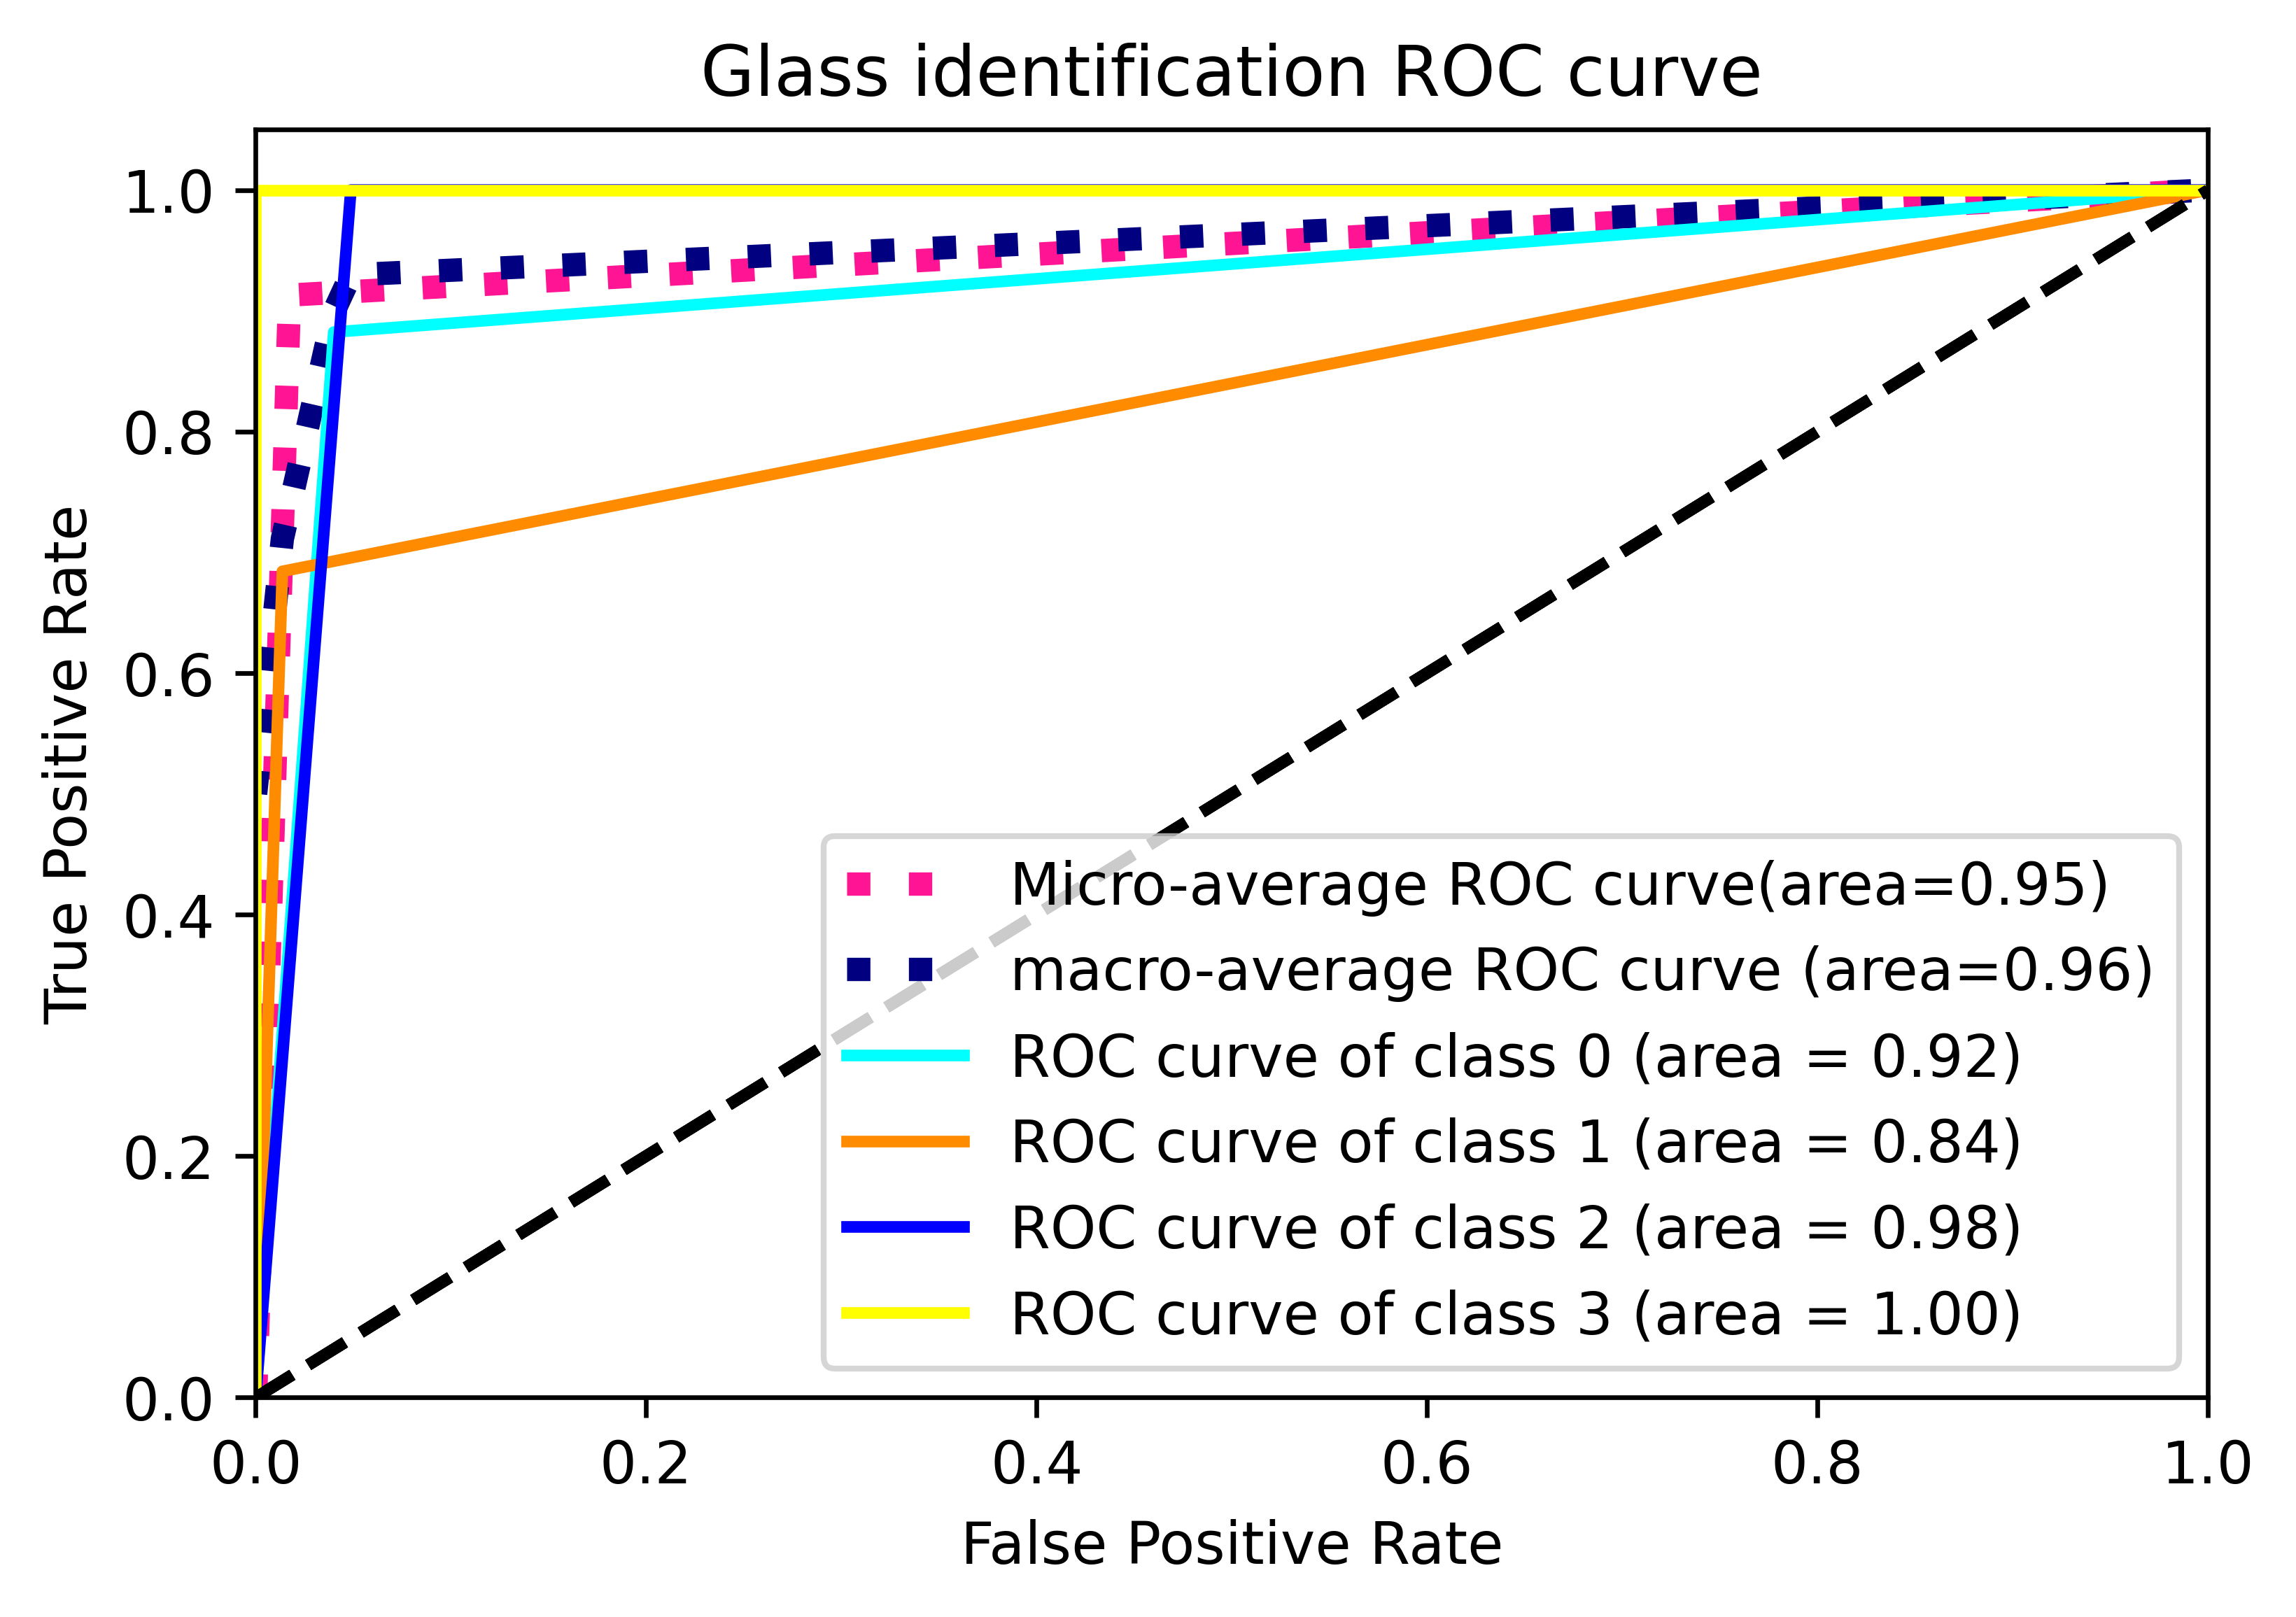

In [63]:
#Plot ROC Curve for ANN model
plot_roc_curve(y_test, ann_pred)

## RandomForest Classifier
### Function to model data using RandomForestClassifier

In [64]:
def RanForClass(X_train,X_test,y_train,y_test):
    rf = RandomForestClassifier(random_state = 42)
    params_rf = {'n_estimators': [50,100,150,200,250],
                'max_depth': [4,6,8,10,12,None],
                'min_samples_leaf': [0.001,0.002,0.003,0.004,0.005],
                'max_features': [0.5,1,'log2','sqrt']}
    
    #GridSearchsv will find best parameter for our model
    grid_rf = GridSearchCV(estimator = rf,param_grid = params_rf,cv = 5)
    grid_rf.fit(X_train,y_train)
    best_hyperparams = grid_rf.best_params_
    
    # Extract the best model from 'grid_rf'
    best_model = grid_rf.best_estimator_
    pred_train = best_model.predict(X_train)
    
    #Predict the test set labels
    y_pred_rf = best_model.predict(X_test)
    
    #add predicted output to dataframe
    pred_glass_df = pd.DataFrame(X_test,columns = df_glass.columns[0:9])
    pred_glass_df['Type'] = y_test.tolist()
    pred_glass_df['predicted_type'] = y_pred_rf.tolist()
    feat_importance = best_model.feature_importances_
    
    return pred_train, y_pred_rf, feat_importance, pred_glass_df

In [65]:
pred_train, y_pred_rf, feat_imp, pred_glass = RanForClass(X_train, X_test, y_train, y_test)
pred_glass.head(10)

RI/Refractive index  Na/Sodium  MG/Magnesium  Al/Aluminum  Si/Silicon  \
0             0.194059   0.649654      0.149044    -0.124615   -0.287774   
1            -0.081961  -0.952418      0.920687    -0.777158    0.385146   
2             1.119533  -0.783206     -1.129682    -0.042095    0.886411   
3             0.542579   0.267974      0.971990    -0.378504   -1.135195   
4            -0.610644  -0.265674      0.850144    -0.484271   -0.116492   
5            -1.173807   1.661641     -1.323844     1.291360    0.989685   
6             0.875799  -0.298903     -1.323844    -0.264605   -0.618131   
7             0.021477  -1.140719      0.446129    -1.308017    1.388423   
8             0.397095   0.285479      0.202543    -0.510876   -0.047923   
9            -0.177737  -1.107489      0.959164    -0.447660    0.449459   

   K/Potassium  Ca/Calcium  Ba/Barium   Fe/Iron  Type  predicted_type  
0    -0.576910    0.204911  -0.434343 -0.516909     4               4  
1     0.224398   -0.275287  -0.434343 -0.516909     0               0  
2    -0.388312    1.558626  -0.434343  2.343705     3               3  
3    -0.230777   -0.443709   0.398423 -0.516909     0               0  
4     0.074153   -0.362566  -0.434343 -0.516909     2               2  
5    -0.576910   -0.588036   0.745552 -0.516909     5               5  
6    -0.163735    2.437627  -0.434343 -0.516909     3               3  
7    -0.138694    0.197472  -0.434343  1.710184     1               0  
8    -0.576910    0.386936  -0.434343 -0.516909     4               4  
9     0.186837   -0.333473  -0.434343  1.042056     0               0

### Train Accuracy is high which means it is not underfitted

In [66]:
# Train Accuracy_score
print(accuracy_score(y_train, pred_train))

1.0


### Test Accuracy is high which means it is not overfitting

In [67]:
# Test Accuracy_score
print(accuracy_score(y_test,y_pred_rf))

0.9456521739130435


In [68]:
#Classification_report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.94      0.89      0.92        19
           2       0.82      0.90      0.86        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.95        92
   macro avg       0.94      0.95      0.94        92
weighted avg       0.95      0.95      0.95        92



### ROC curve Plot for each class

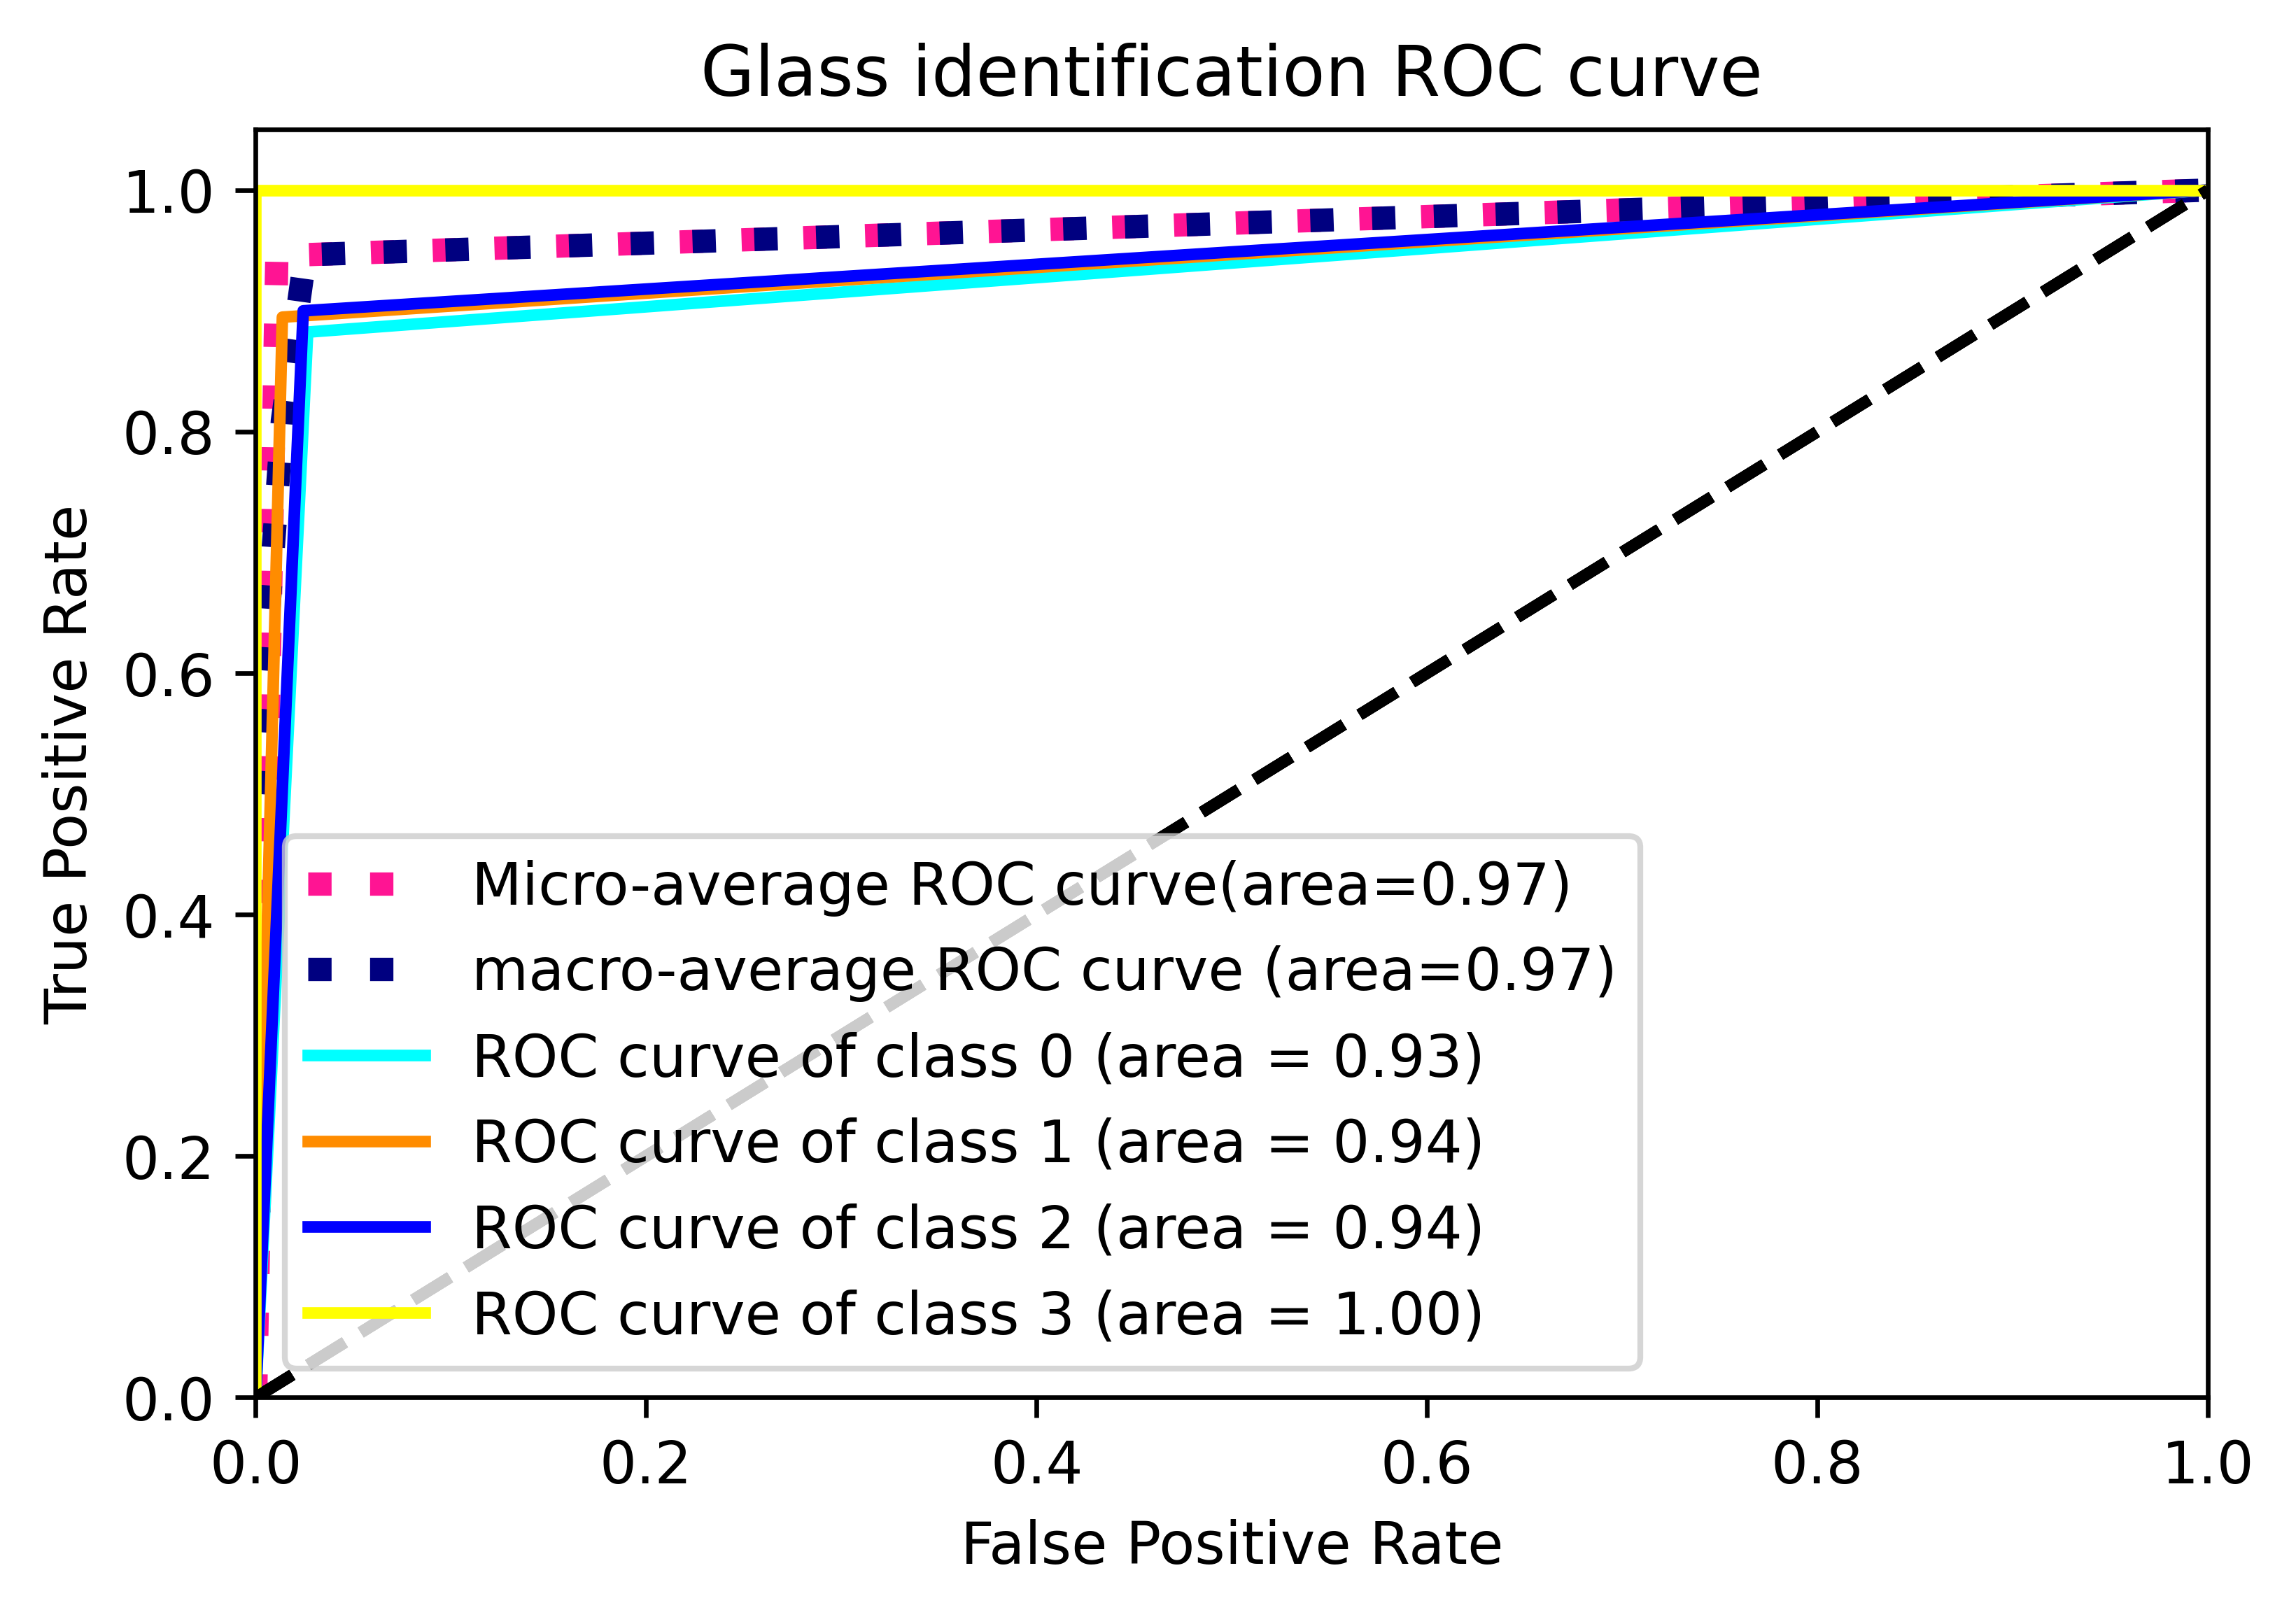

In [69]:
plot_roc_curve(y_test,y_pred_rf)

### Features Importances
We can see that MG/Magnesium is the most important feature

In [70]:
df_glass_1 = df_glass.drop('Type', axis=1)
d = {'features':df_glass_1.columns,'FI':feat_imp}
df = pd.DataFrame(d)
df = df.sort_values(by='FI', ascending=0)
fig = px.bar_polar(df, r="FI", theta="features",
                   color="features", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()